# Pytorch intro


##1. It all starts with a tensor

Tensors are the fundamental data structure in PyTorch. A tensor is an array, that can have any number of dimensions.

Python lists or tuples of numbers are collections of Python objects that are individually allocated in memory.  PyTorch tensors or NumPy arrays, on the other hand, are views over contiguous memory blocks containing unboxed C numeric types rather than Python objects. So they require less memory to be stored.

In Python:
- Numbers in Python are objects.
- Lists in Python are meant for sequential collections of objects.
- The Python interpreter is slow compared to optimized, compiled code.

But PyTorch tensors provide efficient low-level implementations of numerical data structures and related operations on them.

The default data type for tensors is 32-bit floating-point.

More info here: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py

In [1]:
import torch

a = torch.ones(3)
print(a)
print(a[1])
print(float(a[1]))

tensor([1., 1., 1.])
tensor(1.)
1.0


In [2]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
print(points)
print(points.shape)
# we can also initialize it this way
points = torch.zeros(3, 2)
print(points)

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])
torch.Size([3, 2])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])


The output of code cell below is another tensor that presents a different view of the same underlying data. The new tensor is a 1D tensor of size 2, referencing the values of the first row in the points tensor. Does this mean a new chunk of memory was allocated, values were copied into it, and the new memory was returned wrapped in a new tensor object? No :)

Indexing works just as in python lists.

In [3]:
points[0]

tensor([0., 0.])

In [4]:
# controling types in tensors
double_points = torch.ones(10, 2, dtype=torch.double)
print(double_points.dtype)

short_points = torch.tensor([[1, 2], [3, 4]], dtype=torch.short)
print(short_points.dtype)

# there is also a casting operator
double_points_v2 = torch.zeros(10, 2).double()
print(double_points_v2.dtype)

double_points_v3 = torch.zeros(10, 2).to(torch.double)
print(double_points_v3.dtype)

torch.float64
torch.int16
torch.float64
torch.float64


In [5]:
# there are also inplace operations, they are recognizable from a trailing underscore in their name
a = torch.ones(3, 2)
print(a)
a.zero_()
print(a)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])


In [6]:
# storing tensor in gpu
# 1st check which device is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# if not cuda, but cpu, change runtime type to GPU
points_gpu = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]], device='cuda')

In [8]:
points_gpu = points.to(device='cuda')

Doing so returns a new tensor that has the same numerical data, but stored in the RAM of the GPU, rather than in regular system RAM.  At this point, any operation performed on the tensor is carried out on the GPU.

## 2. Handling different types of data

### 2.1 Images

An image is represented as a collection of scalars arranged in a regular grid with a height and a width (in pixels). The most common way to encode colors into numbers is RGB, where a color is defined by three numbers representing the intensity of red, green, and blue.


*kursywa*

In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-09-18 19:40:53--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  19.7MB/s    in 4.8s    

2023-09-18 19:40:58 (13.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [10]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.28.jpg', 'cat.169.jpg', 'cat.90.jpg', 'cat.365.jpg', 'cat.726.jpg', 'cat.379.jpg', 'cat.957.jpg', 'cat.333.jpg', 'cat.20.jpg', 'cat.679.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [11]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [12]:
train_dir

'/tmp/cats_and_dogs_filtered/train'

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

data_path = train_dir

transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

train_dataset = datasets.ImageFolder(data_path, transform=transform)

`data_path` is the file path to the data directory and transform is a list of processing steps built with the transforms module from torchvision. ImageFolder expects the files and directories to be constructed like:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```
where each class has it's own directory (cat and dog) for the images.

In [14]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /tmp/cats_and_dogs_filtered/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [15]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
classes = ('cat', 'dog')

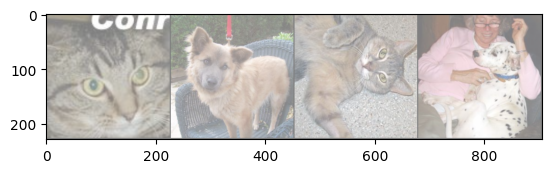

cat   dog   cat   dog  


In [20]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2.2 Tabular data

Columns may contain numerical values or labels, like a string expressing an attribute of the sample, like “blue.”

Information in PyTorch is typically encoded as a number, typically floating-point (though integer types and Boolean are supported as well). Neural networks are mathematical entities that take real numbers as inputs and produce real numbers as output.


In [21]:
import pandas as pd
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.DataFrame(wine.target, columns=['target'])
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [22]:
y

,target
0,0
1,0
2,0
3,0
4,0
...,...
173,2
174,2
175,2
176,2


In [23]:
targets = torch.from_numpy(y.values)
targets.shape

torch.Size([178, 1])

In [24]:
train_X = torch.from_numpy(df.values)
train_X.shape

torch.Size([178, 13])

### 2.3 Time series data

Data loaded from : https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [25]:
!wget --no-check-certificate https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch4/bike-sharing-dataset/hour-fixed.csv

--2023-09-18 19:43:03--  https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch4/bike-sharing-dataset/hour-fixed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148001 (1.1M) [text/plain]
Saving to: ‘hour-fixed.csv’

hour-fixed.csv      100%[===================>]   1.09M  --.-KB/s    in 0.007s  

2023-09-18 19:43:03 (150 MB/s) - ‘hour-fixed.csv’ saved [1148001/1148001]



In [26]:
import os
import torch
import numpy as np


In [27]:
bikes_numpy = np.loadtxt(
    "hour-fixed.csv",
    dtype=np.float32,
    delimiter=",",
    skiprows=1,
    converters={1: lambda x: float(x[8:10])}
)

In [28]:
bikes_numpy

array([[1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 3.0000e+00, 1.3000e+01,
        1.6000e+01],
       [2.0000e+00, 1.0000e+00, 1.0000e+00, ..., 8.0000e+00, 3.2000e+01,
        4.0000e+01],
       [3.0000e+00, 1.0000e+00, 1.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        3.2000e+01],
       ...,
       [1.7377e+04, 3.1000e+01, 1.0000e+00, ..., 7.0000e+00, 8.3000e+01,
        9.0000e+01],
       [1.7378e+04, 3.1000e+01, 1.0000e+00, ..., 1.3000e+01, 4.8000e+01,
        6.1000e+01],
       [1.7379e+04, 3.1000e+01, 1.0000e+00, ..., 1.2000e+01, 3.7000e+01,
        4.9000e+01]], dtype=float32)

In [29]:
bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

In the source data, each row is a separate hour of data.
We want to change the row-per-hour organization so that we have one axis that increases at a rate of one day per index increment, and another axis that represents the hour of the day. The third axis will be our different columns of data.

In a time series dataset such as this one, rows represent successive time-points: there is a dimension along which they are ordered.

This neural network model will need to see a number of sequences of values for each different quantity, such as ride count, time of day, temperature, and weather conditions: N parallel sequences of size C. C stands for channel, in neural network parlance, and is the same as column for 1D data like we have here. The N dimension represents the time axis, here one entry per hour.

In [30]:
bikes.shape

torch.Size([17520, 17])

We want to break up the two-year dataset into wider observation periods, like days. This way we’ll have N (for number of samples) collections of C sequences of length L. In other words, our time series dataset would be a tensor of dimension 3 and shape N × C × L. The C would remain our 17 channels, while L would be 24: 1 per hour of the day. There’s no particular reason why we must use chunks of 24 hours, though the general daily rhythm is likely to give us patterns we can exploit for predictions. We could also use 7 × 24 = 168 hour blocks to chunk by week instead, if we desired. All of this depends, naturally, on our dataset having the right size--the number of rows must be a multiple of 24 or 168. Also, for this to make sense, we cannot have gaps in the time series.

17,379 hours, 17 **columns**

In [31]:
bikes.shape

torch.Size([17520, 17])

In [32]:
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape

torch.Size([730, 24, 17])

To get to our desired N × C × L ordering, we need to transpose the tensor.

In [33]:
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape

torch.Size([730, 17, 24])

## 3. Learning

The learning might be described like:
Given input data and corresponding output (ground truth) and initial values of weights, we feed the data to the model (calculating so called forward pass) and a measure of the error is evaluated by comparing the resulting outputs to the ground truth.

Our goal is to optimize the parameters of the model (weights of the network). So we need to update the values of the weights in the direction that leads to a decrease in the error.

A loss function (or cost function) is a function that computes a single numerical value that the learning process will attempt to minimize. The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model.

PyTorch tensors can remember where they come from, in terms of the operations and parent tensors that originated them, and they can automatically provide the chain of derivatives of such operations with respect to their inputs.  PyTorch will automatically provide the gradient of that expression with respect to its input parameters. (autograd).


Below an easy example of linear model.

In [34]:
import torch

y_true = torch.tensor([0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0])
x = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

x_scaled = 0.1 * x

In [35]:
def model(x, w, b):
    return w * x + b

def loss_fn(y_true, y):
    squared_diffs = (y_true - y)**2
    return squared_diffs.mean()

`requires_grad=True argument` is telling PyTorch to track the entire family tree of tensors resulting from operations on `params`.

In [36]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

The grad attribute of params contains the derivatives of the loss with respect to each element of params.

In [37]:
loss = loss_fn(model(x, *params), y_true)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

Example training loop could look like this:

In [38]:
def training_loop(n_epochs, learning_rate, params, x, y_true):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        y_pred = model(x, *params)
        loss = loss_fn(y_true, y_pred)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 100 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [39]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    x=x_scaled,
    y_true=y_true)

Epoch 100, Loss 22.148710
Epoch 200, Loss 16.608067
Epoch 300, Loss 12.664559
Epoch 400, Loss 9.857802
Epoch 500, Loss 7.860115
Epoch 600, Loss 6.438284
Epoch 700, Loss 5.426309
Epoch 800, Loss 4.706046
Epoch 900, Loss 4.193405
Epoch 1000, Loss 3.828538
Epoch 1100, Loss 3.568848
Epoch 1200, Loss 3.384018
Epoch 1300, Loss 3.252462
Epoch 1400, Loss 3.158830
Epoch 1500, Loss 3.092191
Epoch 1600, Loss 3.044759
Epoch 1700, Loss 3.011001
Epoch 1800, Loss 2.986974
Epoch 1900, Loss 2.969871
Epoch 2000, Loss 2.957698
Epoch 2100, Loss 2.949035
Epoch 2200, Loss 2.942870
Epoch 2300, Loss 2.938481
Epoch 2400, Loss 2.935356
Epoch 2500, Loss 2.933134
Epoch 2600, Loss 2.931554
Epoch 2700, Loss 2.930426
Epoch 2800, Loss 2.929626
Epoch 2900, Loss 2.929054
Epoch 3000, Loss 2.928648
Epoch 3100, Loss 2.928361
Epoch 3200, Loss 2.928154
Epoch 3300, Loss 2.928006
Epoch 3400, Loss 2.927904
Epoch 3500, Loss 2.927830
Epoch 3600, Loss 2.927776
Epoch 3700, Loss 2.927739
Epoch 3800, Loss 2.927713
Epoch 3900, Loss 2

tensor([  5.3671, -17.3012], requires_grad=True)

We can choose an optimizer as well.

In [40]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [41]:
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate) # stochastic gradient descent

In [42]:
def training_loop(n_epochs, optimizer, params, x, y_true):
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x, *params)
        loss = loss_fn(y_true, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [43]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    params=params,
    x=x_scaled,
    y_true=y_true)

Epoch 100, Loss 22.148710
Epoch 200, Loss 16.608068
Epoch 300, Loss 12.664563
Epoch 400, Loss 9.857809
Epoch 500, Loss 7.860120
Epoch 600, Loss 6.438289
Epoch 700, Loss 5.426312
Epoch 800, Loss 4.706045
Epoch 900, Loss 4.193405
Epoch 1000, Loss 3.828538
Epoch 1100, Loss 3.568848
Epoch 1200, Loss 3.384018
Epoch 1300, Loss 3.252462
Epoch 1400, Loss 3.158830
Epoch 1500, Loss 3.092191
Epoch 1600, Loss 3.044759
Epoch 1700, Loss 3.011001
Epoch 1800, Loss 2.986974
Epoch 1900, Loss 2.969871
Epoch 2000, Loss 2.957698
Epoch 2100, Loss 2.949035
Epoch 2200, Loss 2.942870
Epoch 2300, Loss 2.938481
Epoch 2400, Loss 2.935356
Epoch 2500, Loss 2.933134
Epoch 2600, Loss 2.931554
Epoch 2700, Loss 2.930426
Epoch 2800, Loss 2.929626
Epoch 2900, Loss 2.929054
Epoch 3000, Loss 2.928648
Epoch 3100, Loss 2.928361
Epoch 3200, Loss 2.928154
Epoch 3300, Loss 2.928006
Epoch 3400, Loss 2.927904
Epoch 3500, Loss 2.927830
Epoch 3600, Loss 2.927776
Epoch 3700, Loss 2.927739
Epoch 3800, Loss 2.927713
Epoch 3900, Loss 2

tensor([  5.3671, -17.3012], requires_grad=True)

# 4. Building neural net

The basic building block of neural nets is the neuron.

It is a linear transformation of the input (for example, multiplying the input by a number [the weight] and adding a constant [the bias]) followed by the application of a fixed nonlinear function (activation function).

We can write this out as o = f(w * x + b), where f is an activation function, w weights, b biases and x input.

The simplest unit in neural networks is a linear operation (scaling + offset) followed by an activation function.

There are many activation functions, but ReLU (for rectified linear unit) is currently considered one of the best-performing general activation functions.
The Sigmoid activation function, also known as the logistic function, was widely used in early deep learning work but has since fallen out of common use except where we explicitly want to move to the 0...1 range: for example, when the output should be a probability.

Activation functions have two main characteristics:
- They are nonlinear (nonlinearity allows the overall network to approximate more complex functions)
- They are differentiable (gradients can be computed through them)

Without these characteristics, the network either falls back to being a linear model or becomes difficult to train.
(https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)


## Linear model

In [44]:
# simple linear model in pytorch

import torch.nn as nn

x = torch.ones(1)
linear_model = nn.Linear(1, 1) # one input feature, one output
linear_model(x)

tensor([0.6839], grad_fn=<AddBackward0>)

In [45]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.8973]], requires_grad=True),
 Parameter containing:
 tensor([-0.2134], requires_grad=True))

Pytorch allows us to batch inputs.
Any module in nn is written to produce outputs for a batch of multiple inputs at the same time.

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!


In [46]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.6839],
        [0.6839],
        [0.6839],
        [0.6839],
        [0.6839],
        [0.6839],
        [0.6839],
        [0.6839],
        [0.6839],
        [0.6839]], grad_fn=<AddmmBackward0>)

In [47]:
import torch
from sklearn.model_selection import train_test_split

y = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
X = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = torch.tensor(X_train) * 0.1
X_test = torch.tensor(X_test) * 0.1
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)


To make it possible to use bathing here we reshape our B inputs to B × Nin, where Nin is 1.

In [48]:
# adds an extra dimension to our tensor

y_train = y_train.unsqueeze(1)
X_train = X_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [49]:
X_train.shape

torch.Size([7, 1])

In [50]:
y_train.shape

torch.Size([7, 1])

In [51]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.8973]], requires_grad=True),
 Parameter containing:
 tensor([-0.2134], requires_grad=True)]

In [52]:
def training_loop(n_epochs, optimizer, model, loss_fn, X_train, X_val, y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        y_pred_train = model(X_train)
        loss_train = loss_fn(y_train, y_pred_train)

        y_pred_val = model(X_val)
        loss_val = loss_fn(y_val, y_pred_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 100 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

Pytorch has many implemented loss functions, you can read about them here:
- https://blog.paperspace.com/pytorch-loss-functions/
- https://neptune.ai/blog/pytorch-loss-functions

In [53]:
loss_fn = nn.MSELoss() # we will use MSE for regression

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "https://raw.githubusercontent.com/AviatorMoser/keras-mnist-tutorial/master/gradient_descent.png" width = "450">

<img src = "https://raw.githubusercontent.com/AviatorMoser/keras-mnist-tutorial/master/learning_rate.png" width = "400">


<img src = 'https://raw.githubusercontent.com/AviatorMoser/keras-mnist-tutorial/master/complicated_loss_function.png' width = "450" >

In [54]:
import torch.optim as optim

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [55]:
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=loss_fn,
    X_train=X_train,
    X_val=X_test,
    y_train=y_train,
    y_val=y_test)

Epoch 1, Training loss 372.5168, Validation loss 336.4075
Epoch 100, Training loss 22.5505, Validation loss 19.7059
Epoch 200, Training loss 15.8174, Validation loss 15.1917
Epoch 300, Training loss 11.4016, Validation loss 12.0210
Epoch 400, Training loss 8.5055, Validation loss 9.7715
Epoch 500, Training loss 6.6062, Validation loss 8.1583
Epoch 600, Training loss 5.3605, Validation loss 6.9888
Epoch 700, Training loss 4.5436, Validation loss 6.1314
Epoch 800, Training loss 4.0078, Validation loss 5.4959
Epoch 900, Training loss 3.6564, Validation loss 5.0198
Epoch 1000, Training loss 3.4259, Validation loss 4.6596
Epoch 1100, Training loss 3.2748, Validation loss 4.3845
Epoch 1200, Training loss 3.1757, Validation loss 4.1726
Epoch 1300, Training loss 3.1107, Validation loss 4.0082
Epoch 1400, Training loss 3.0680, Validation loss 3.8797
Epoch 1500, Training loss 3.0401, Validation loss 3.7787
Epoch 1600, Training loss 3.0217, Validation loss 3.6989
Epoch 1700, Training loss 3.0097,

## First neural net

In [56]:
from torch.nn.modules.activation import ReLU
# net with 1 input and 1 output (12 hidden)
model = nn.Sequential(
            nn.Linear(1, 12),
            nn.Tanh(),
            nn.Linear(12, 1))
model

Sequential(
  (0): Linear(in_features=1, out_features=12, bias=True)
  (1): Tanh()
  (2): Linear(in_features=12, out_features=1, bias=True)
)

In [57]:
for name, param in model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([12, 1])
0.bias torch.Size([12])
2.weight torch.Size([1, 12])
2.bias torch.Size([1])


In [58]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    X_train=X_train,
    X_val=X_test,
    y_train=y_train,
    y_val=y_test)

Epoch 1, Training loss 184.5808, Validation loss 155.5490
Epoch 100, Training loss 54.4767, Validation loss 37.0354
Epoch 200, Training loss 27.3186, Validation loss 17.3802
Epoch 300, Training loss 16.6943, Validation loss 9.8200
Epoch 400, Training loss 11.9175, Validation loss 6.5155
Epoch 500, Training loss 9.5064, Validation loss 5.0648
Epoch 600, Training loss 8.0394, Validation loss 4.3645
Epoch 700, Training loss 6.9919, Validation loss 3.9597
Epoch 800, Training loss 6.1692, Validation loss 3.6781
Epoch 900, Training loss 5.4917, Validation loss 3.4599
Epoch 1000, Training loss 4.9149, Validation loss 3.2807
Epoch 1100, Training loss 4.4098, Validation loss 3.1113
Epoch 1200, Training loss 3.9763, Validation loss 2.9372
Epoch 1300, Training loss 3.6226, Validation loss 2.7775
Epoch 1400, Training loss 3.3406, Validation loss 2.6441
Epoch 1500, Training loss 4.4994, Validation loss 1.9463
Epoch 1600, Training loss 4.9117, Validation loss 2.2441
Epoch 1700, Training loss 3.9716,

# 5. Image recognition

In [59]:
from torchvision import datasets
import torch
import matplotlib.pyplot as plt

data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:14<00:00, 12077714.13it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


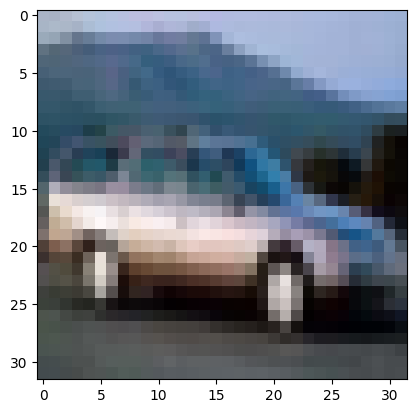

In [60]:
img, label = cifar10[4]
plt.imshow(img)
plt.show()

As described before in section about loading data, we can perform transform operations on this dataset.

In [61]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [62]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img) # turning image to tensor to pass it to NeuralNet
img_t.shape # 3 channels of RGB, 32x32 size

torch.Size([3, 32, 32])

Let's load the dataset and turn it to tensor.
Additionally `transforms.ToTensor` transform turns the data into a 32-bit floating-point per channel, scaling the values down from 0.0 to 1.0.

Transforms can be chained using `transforms.Compose`. It’s a good practice to normalize the dataset so that each channel has zero mean, this is what `transforms.Normalize` do.

In [63]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [64]:
# stacking tensors in additional dimension
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

Normalizing the dataset

In [65]:
mean = imgs.view(3, -1).mean(dim=1)
mean

tensor([0.4914, 0.4822, 0.4465])

In [66]:
std = imgs.view(3, -1).std(dim=1)
std

tensor([0.2470, 0.2435, 0.2616])

In [67]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465],
                             [0.2470, 0.2435, 0.2616])
    ]))
transformed_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data-unversioned/p1ch7/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
           )

Our image after normalization

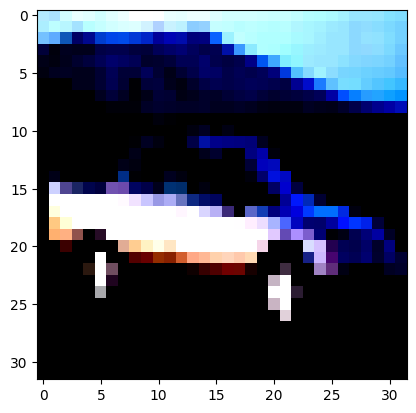

In [68]:
image, _ = transformed_cifar10[4]
plt.imshow(image.permute(1, 2, 0))
plt.show()

Let's do binary classification

In [69]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(to_tensor(img), label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(to_tensor(img), label_map[label]) for img, label in cifar10_val if label in [0, 2]]

To create model for simple fully connected net, we need to flatten the inputs from size 32 × 32 × 3 to 3072.

In [70]:
import torch.nn as nn

n_out = 2
n_in = 3072
hidden = 512

As we have 2 outputs we will use Softmax here to select the class with the highest probability.
- https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax/
- https://deepai.org/machine-learning-glossary-and-terms/softmax-layer

In [71]:
model = nn.Sequential(
            nn.Linear(n_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_out),
            nn.Softmax(dim=1)
        )

As we chose as the loss function NLLLoss, it expects log probabilities.
https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

So we switch nn.Softmax(dim=1) to nn.LogSoftmax(dim=1)

In [76]:
model = nn.Sequential(
            nn.Linear(n_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_out),
            nn.LogSoftmax(dim=1)
        )

In [77]:
learning_rate = 1e-2
n_epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

Please read about Gradient Descent, Stochastic Gradient Descent and Minibatch Stochastic Gradient Descent here:
https://d2l.ai/chapter_optimization/index.html

In [78]:
for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 1.185311
Epoch: 1, Loss: 1.164590
Epoch: 2, Loss: 1.381441
Epoch: 3, Loss: 1.376193
Epoch: 4, Loss: 1.119919
Epoch: 5, Loss: 1.212987
Epoch: 6, Loss: 1.693740
Epoch: 7, Loss: 0.832529
Epoch: 8, Loss: 1.352289
Epoch: 9, Loss: 1.204608
Epoch: 10, Loss: 1.303428
Epoch: 11, Loss: 1.307679
Epoch: 12, Loss: 1.387713
Epoch: 13, Loss: 1.674826
Epoch: 14, Loss: 1.052518
Epoch: 15, Loss: 2.432188
Epoch: 16, Loss: 2.261212
Epoch: 17, Loss: 1.535961
Epoch: 18, Loss: 2.452604
Epoch: 19, Loss: 1.305488
Epoch: 20, Loss: 1.353643
Epoch: 21, Loss: 1.423222
Epoch: 22, Loss: 1.218291
Epoch: 23, Loss: 0.826171
Epoch: 24, Loss: 0.845826
Epoch: 25, Loss: 1.228000
Epoch: 26, Loss: 0.630902
Epoch: 27, Loss: 2.133204
Epoch: 28, Loss: 0.692698
Epoch: 29, Loss: 1.009678
Epoch: 30, Loss: 1.894916
Epoch: 31, Loss: 2.958113
Epoch: 32, Loss: 1.345735
Epoch: 33, Loss: 1.011866
Epoch: 34, Loss: 2.068646
Epoch: 35, Loss: 1.472834
Epoch: 36, Loss: 1.052137
Epoch: 37, Loss: 1.638085
Epoch: 38, Loss: 2.420

# Task 1 (2.5 points)

Implement multiclass classification on all classes from cifar10 using CrossEntropyLoss.
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Implement training loop using minibatches.

In [75]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465],
                             [0.2470, 0.2435, 0.2616])
    ]))



n_out = 10
n_in = 3072
hidden = 512

model = nn.Sequential(
            nn.Linear(n_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_out),
            nn.LogSoftmax(dim=1)
        )

learning_rate = 1e-2
n_epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# crossentropy loss

loss_fn = nn.CrossEntropyLoss()

# train in minibatches

train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=True)

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 1.799006
Epoch: 1, Loss: 1.680776
Epoch: 2, Loss: 1.268399
Epoch: 3, Loss: 1.504436
Epoch: 4, Loss: 1.481860
Epoch: 5, Loss: 1.475464
Epoch: 6, Loss: 1.071688
Epoch: 7, Loss: 0.765258
Epoch: 8, Loss: 1.608443
Epoch: 9, Loss: 0.958725
Epoch: 10, Loss: 0.828054
Epoch: 11, Loss: 0.952797
Epoch: 12, Loss: 0.856999
Epoch: 13, Loss: 0.571009
Epoch: 14, Loss: 0.952858
Epoch: 15, Loss: 0.853767
Epoch: 16, Loss: 0.962300
Epoch: 17, Loss: 0.892032
Epoch: 18, Loss: 0.942823
Epoch: 19, Loss: 0.628071
Epoch: 20, Loss: 0.859537
Epoch: 21, Loss: 0.829348
Epoch: 22, Loss: 0.889300
Epoch: 23, Loss: 0.691489
Epoch: 24, Loss: 0.731732
Epoch: 25, Loss: 0.366327
Epoch: 26, Loss: 0.606481
Epoch: 27, Loss: 0.689806
Epoch: 28, Loss: 0.509173
Epoch: 29, Loss: 0.645230
Epoch: 30, Loss: 0.171143
Epoch: 31, Loss: 1.195959
Epoch: 32, Loss: 0.347512
Epoch: 33, Loss: 0.477364
Epoch: 34, Loss: 0.538375
Epoch: 35, Loss: 0.121554
Epoch: 36, Loss: 0.212162
Epoch: 37, Loss: 0.540505
Epoch: 38, Loss: 0.215

## Convolutions

One of many problems with previous nets that classified images is that they learned each pixel in the image instead of learning shapes.

We had both too many parameters (making it easier for the model to memorize the training set) and no position independence (making it harder to generalize).

To solve this we will use another linear operation: convolution.

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.



<img src = 'https://raw.githubusercontent.com/AviatorMoser/keras-mnist-tutorial/master/convolution.gif' >

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.

<img src = 'https://raw.githubusercontent.com/AviatorMoser/keras-mnist-tutorial/master/kernels.png' >

Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called **max pooling**, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).

<img src = 'https://raw.githubusercontent.com/AviatorMoser/keras-mnist-tutorial/master/max_pooling.png' width="450">

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*

The same kernel, and thus each weight in the kernel, is reused across the whole image.

So, by using convolutions we get:
- Models with a lot fewer parameters (now number of parameters don't depend on pixels in the image, as was the case in our fully connected model, but rather on the size of the convolution kernel)
- Local operations on neighborhoods

In [79]:
import torch.nn as nn

In [80]:
conv = nn.Conv2d(3, 16, kernel_size=(3, 3)) # input channels 3, output channels 16, kernel 3x3
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

For a single output pixel value, our kernel would consider in this case in_ch = 3 input channels, so the weight component for a single output pixel value is of shape in_ch × 3 × 3.

And we have as many of those above as we have output channels, here out_ch = 16, so the complete weight tensor is out_ch × in_ch × 3 × 3.

We have smaller models looking for local patterns whose weights are optimized across the entire image.

It is worth noting, that for edge pixels we can also use padding, which means adding empty pixels so that kernels can use edge pixes.

https://d2l.ai/chapter_convolutional-neural-networks/padding-and-strides.html

In [81]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

After conv layers we are using downsampling:
https://d2l.ai/chapter_convolutional-neural-networks/pooling.html

Downsampling could in principle occur in different ways.
- Average the four (or more) pixels.
- Take the maximum of the four (or more) pixels.
- Perform a strided convolution, where only every Nth pixel is calculated.

Combining convolutions and downsampling can help us recognize larger structures.

So when we chain them like conv -> pooling -> conv -> pooling, the first set of kernels operates on small neighborhoods on first-order, low-level features, while the second set of kernels effectively operates on wider neighborhoods, producing features that are compositions of the previous features.

In [82]:
pool = nn.MaxPool2d(2)
pool

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [83]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # 3 RGB channels mapped to 16 channels after convolution and size of image (32x32) thanks to padding
            nn.ReLU(), # activation function
            nn.MaxPool2d(2), # max pooling resuling in 16 channels but size 16x16
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # 16 channels to 8 channels, size 16x16 thanks to padding of 1 and kernel 3x3
            nn.ReLU(),
            nn.MaxPool2d(2), # 8 channels, output size 8x8
            nn.Linear(8 * 8 * 8, 32), # flattening 8 channels and size 8x8 to single vector of size 8*8*8
            nn.ReLU(),
            nn.Linear(32, 2) # 2 output neurons
)

### Using Pytorch nn.Module



In [84]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [85]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format( epoch,
                loss_train / len(train_loader)))

In [86]:
import torch

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

Epoch 1, Training loss 0.691016400315959
Epoch 10, Training loss 0.48963951077430873
Epoch 20, Training loss 0.362843584387925
Epoch 30, Training loss 0.3277677515889429
Epoch 40, Training loss 0.31194789603257633
Epoch 50, Training loss 0.298839457285632
Epoch 60, Training loss 0.28512574063175045
Epoch 70, Training loss 0.2773948965748404
Epoch 80, Training loss 0.26864624763749967
Epoch 90, Training loss 0.25588402901865115
Epoch 100, Training loss 0.24272050186517133


# Task 2 (2.5 points)

- Add validation method and call it once per epoch on validation dataset
- Play with the conv net architecture:
  - Add regularization like Dropout or BatchNorm
  - Add more layers of convolutions and see how it changes
  - Change kernel size of convolutions
- Read and compare/implement (just call pytorch optimizer) in our Net different optimizers (try Adam, SGD, Momentum). Plot how the learning look for them.


In [94]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    training_losses = []
    validation_losses = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format( epoch,
                loss_train / len(train_loader)))

        # validation
        if epoch == 1 or epoch % 10 == 0:
          val_loss_total = 0.0
          with torch.no_grad():
              for val_imgs, val_labels in val_loader:
                  val_outputs = model(val_imgs)
                  val_loss = loss_fn(val_outputs, val_labels)
                  val_loss_total += val_loss.item()
              print("Validation loss {}".format(val_loss_total / len(val_loader)))
        training_losses.append(loss_train)
        validation_losses.append(val_loss_total)

    # plot losses
    plt.plot(training_losses, label="training loss")
    plt.plot(validation_losses, label="validation loss")
    plt.legend()
    plt.show()

In [95]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

Epoch 1, Training loss 0.6941196451521223
Validation loss 0.6902839969843626
Epoch 10, Training loss 0.4753779093171381
Validation loss 0.4844355555251241
Epoch 20, Training loss 0.3798902217939401
Validation loss 0.4441220546141267
Epoch 30, Training loss 0.34358362796579955
Validation loss 0.34760916233062744
Epoch 40, Training loss 0.32027257902986683
Validation loss 0.3168454235419631
Epoch 50, Training loss 0.3023212166728487
Validation loss 0.36907423799857497
Epoch 60, Training loss 0.28989267766855326
Validation loss 0.2971651181578636
Epoch 70, Training loss 0.2740234809506471
Validation loss 0.28700894583016634
Epoch 80, Training loss 0.26017625729559335
Validation loss 0.2908688331954181
Epoch 90, Training loss 0.24802825353138006
Validation loss 0.2964518121443689
Epoch 100, Training loss 0.23726705252934413
Validation loss 0.4661910068243742


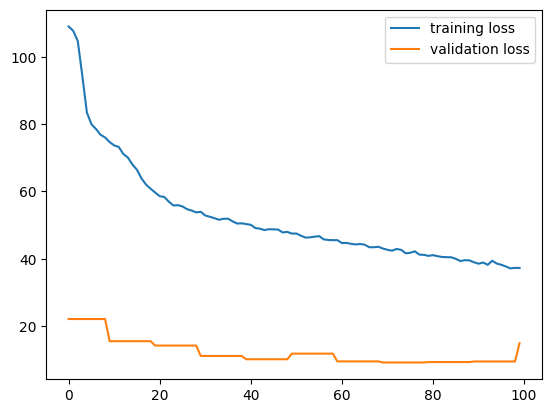

In [96]:
import torch

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

## Regularization


In [97]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)

        # add regularization
        self.drop = nn.Dropout2d(0.25)
        self.batch_norm1 = nn.BatchNorm2d(16)

    def forward(self, x):
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.act1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.pool2(out)
        out = self.drop(out)
        out = out.view(-1, 8 * 8 * 8)
        out = self.fc1(out)
        out = self.act3(out)
        out = self.fc2(out)
        return out

Epoch 1, Training loss 0.5875043557707671
Validation loss 0.4972136225551367
Epoch 10, Training loss 0.3444851559058876
Validation loss 0.3924149153754115
Epoch 20, Training loss 0.29875788495988603
Validation loss 0.3237598519772291
Epoch 30, Training loss 0.2835499470590786
Validation loss 0.3367316070944071
Epoch 40, Training loss 0.2609351823569103
Validation loss 0.3243717667646706
Epoch 50, Training loss 0.24168723494194116
Validation loss 0.3095725830644369
Epoch 60, Training loss 0.22875048044570692
Validation loss 0.2868789415806532
Epoch 70, Training loss 0.21565003944620206
Validation loss 0.29123093001544476
Epoch 80, Training loss 0.20212456835493162
Validation loss 0.3197456798516214
Epoch 90, Training loss 0.18919694777222196
Validation loss 0.28235921263694763
Epoch 100, Training loss 0.1784010620633508
Validation loss 0.29626668989658356


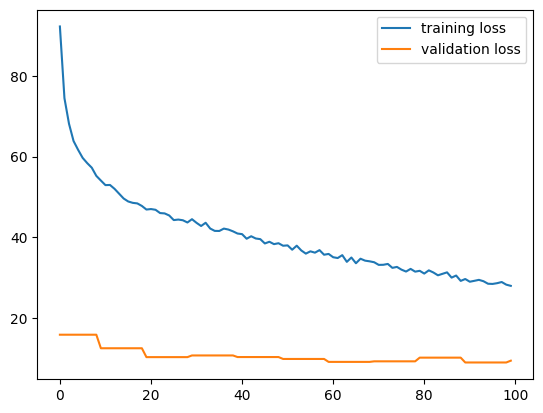

In [98]:
import torch

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

## Additional layers


In [101]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(4, 2, kernel_size=3, padding=1)
        self.act5 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(2 * 2 * 2, 32)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)


        # add regularization
        self.drop = nn.Dropout2d(0.25)
        self.batch_norm1 = nn.BatchNorm2d(16)

        # additional layers
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(4, 2, kernel_size=3, padding=1)
        self.act5 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)


    def forward(self, x):
        out = self.pool1(self.batch_norm1(self.act1(self.conv1(x))))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.drop(out)
        out = self.pool3(self.act4(self.conv3(out)))
        out = self.pool4(self.act5(self.conv4(out)))
        out = out.view(-1, 2 * 2 * 2)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

Epoch 1, Training loss 0.6935693948132218
Validation loss 0.6904090754687786
Epoch 10, Training loss 0.4365582319961232
Validation loss 0.41619488783180714
Epoch 20, Training loss 0.3594446587524596
Validation loss 0.35510123427957296
Epoch 30, Training loss 0.3293976378478822
Validation loss 0.3435376202687621
Epoch 40, Training loss 0.30453377905165313
Validation loss 0.3250904572196305
Epoch 50, Training loss 0.28193617635851453
Validation loss 0.32579740323126316
Epoch 60, Training loss 0.2728289856937281
Validation loss 0.3298212978988886
Epoch 70, Training loss 0.2570811519577245
Validation loss 0.36809989297762513
Epoch 80, Training loss 0.25207520983401377
Validation loss 0.29438618337735534
Epoch 90, Training loss 0.24269091888407993
Validation loss 0.30012879986315966
Epoch 100, Training loss 0.23577262432711898
Validation loss 0.34458356350660324


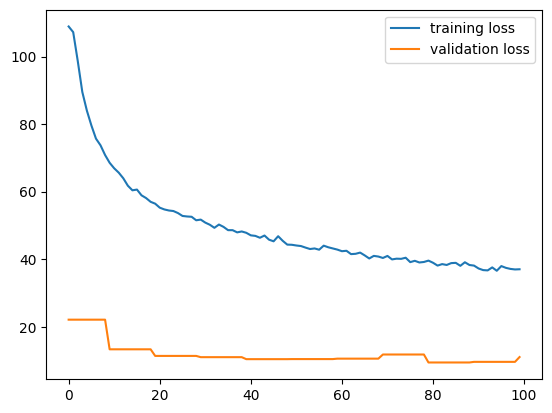

In [102]:
import torch

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

## Kernel size


In [110]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

Epoch 1, Training loss 0.6912948743552919
Validation loss 0.6878366526216269
Epoch 10, Training loss 0.45356562448914645
Validation loss 0.4374464740976691
Epoch 20, Training loss 0.3429734598679148
Validation loss 0.32952965097501874
Epoch 30, Training loss 0.30861260813132974
Validation loss 0.31427244981750846
Epoch 40, Training loss 0.2876383882893878
Validation loss 0.31483131367713213
Epoch 50, Training loss 0.27019255072068254
Validation loss 0.2932111672125757
Epoch 60, Training loss 0.24979177392592097
Validation loss 0.2846925207413733
Epoch 70, Training loss 0.22988591746539827
Validation loss 0.2833706298843026
Epoch 80, Training loss 0.21677017857314676
Validation loss 0.31163994735106826
Epoch 90, Training loss 0.20161409687938964
Validation loss 0.279972346033901
Epoch 100, Training loss 0.18774169151950035
Validation loss 0.27321508526802063


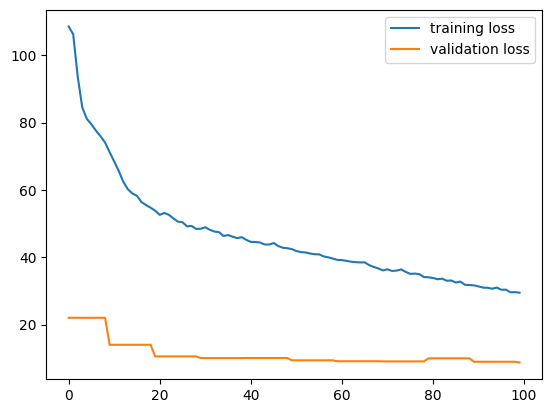

In [111]:
import torch

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

## Different optimizers

Epoch 1, Training loss 0.5547397613145744
Validation loss 0.5027065183967352
Epoch 10, Training loss 0.2822132801079446
Validation loss 0.3354822206310928
Epoch 20, Training loss 0.20827552540951474
Validation loss 0.36751274252310395
Epoch 30, Training loss 0.165411215963637
Validation loss 0.4723435821942985
Epoch 40, Training loss 0.13085489333340317
Validation loss 0.6764512341469526
Epoch 50, Training loss 0.120290043995164
Validation loss 0.7494873497635126
Epoch 60, Training loss 0.1126193291074626
Validation loss 0.7957430640235543
Epoch 70, Training loss 0.15470159136850364
Validation loss 0.8177708918228745
Epoch 80, Training loss 0.12046109060430603
Validation loss 1.260301106609404
Epoch 90, Training loss 0.15500132918096843
Validation loss 1.176299825310707
Epoch 100, Training loss 0.12961034367015217
Validation loss 1.0763105535879731


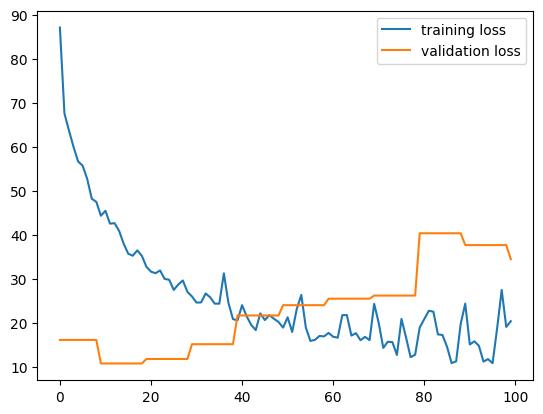

In [112]:
import torch

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

Epoch 1, Training loss 0.5669390124500178
Validation loss 0.9759048093110323
Epoch 10, Training loss 0.2774003851375762
Validation loss 0.3102586017921567
Epoch 20, Training loss 0.2001394562565597
Validation loss 0.3111735098063946
Epoch 30, Training loss 0.11677930540268779
Validation loss 0.3771828180179
Epoch 40, Training loss 0.05694776900693964
Validation loss 0.6980927968397737
Epoch 50, Training loss 0.026708181272705744
Validation loss 0.7159547712653875
Epoch 60, Training loss 0.004176971343550594
Validation loss 0.8807359924539924
Epoch 70, Training loss 0.0013397629059492284
Validation loss 1.0409646648913622
Epoch 80, Training loss 0.0005567772944979566
Validation loss 1.140135328285396
Epoch 90, Training loss 0.00035664331840429454
Validation loss 1.1958132833242416
Epoch 100, Training loss 0.00025523140961893797
Validation loss 1.2374370638281107


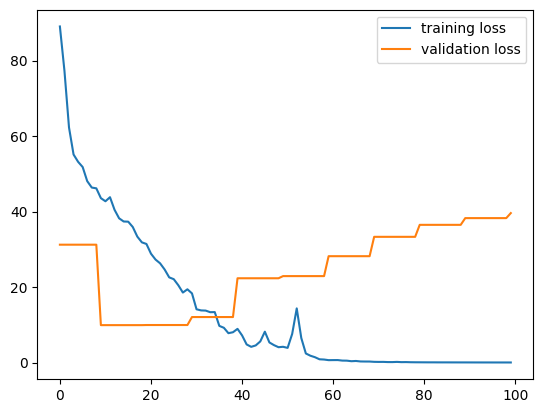

In [113]:
import torch

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

Epoch 1, Training loss 0.5674656825080798
Validation loss 0.4773153178393841
Epoch 10, Training loss 0.31716577006373436
Validation loss 0.32474809838458896
Epoch 20, Training loss 0.27586982418207606
Validation loss 0.2940531335771084
Epoch 30, Training loss 0.255648660147266
Validation loss 0.27708982676267624
Epoch 40, Training loss 0.23712097995789946
Validation loss 0.2755945869721472
Epoch 50, Training loss 0.22576983548273707
Validation loss 0.2646930832415819
Epoch 60, Training loss 0.2157851909850813
Validation loss 0.2664595963433385
Epoch 70, Training loss 0.20515284250686122
Validation loss 0.2669260371476412
Epoch 80, Training loss 0.19604893811758917
Validation loss 0.26547043514437973
Epoch 90, Training loss 0.19065891566929544
Validation loss 0.27317337319254875
Epoch 100, Training loss 0.18251493478276928
Validation loss 0.26570514729246497


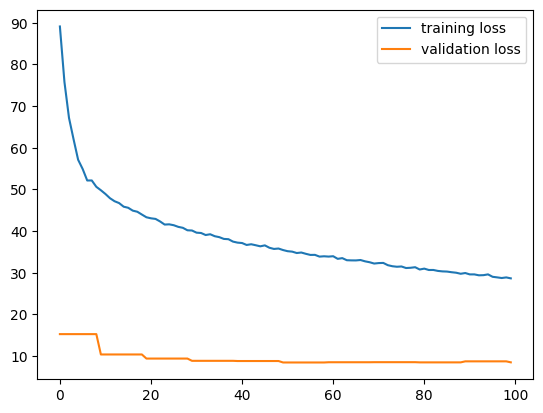

In [114]:
import torch

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)